In [1]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd /content/gdrive/MyDrive/glide-text2im

Mounted at /content/gdrive
/content/gdrive/MyDrive/glide-text2im


In [2]:
import os
import torch
import numpy as np
from PIL import Image

from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import create_model_and_diffusion, model_and_diffusion_defaults, model_and_diffusion_defaults_upsampler

class GLIDE:

  def __init__(self, guidance_scale=3.0, upsample_temp=0.997, ts_base=100, ts_upsample=None):

    has_cuda = torch.cuda.is_available()
    self.device = "cuda" if has_cuda else "cpu"
    
    self.batch_size = 1
    self.guidance_scale = guidance_scale
    self.upsample_temp = upsample_temp

    options = model_and_diffusion_defaults()
    options['use_fp16'] = has_cuda
    options['timestep_respacing'] = str(ts_base)
    self.options = options
    options_up = model_and_diffusion_defaults_upsampler()
    options_up['use_fp16'] = has_cuda
    options_up['timestep_respacing'] = str(ts_upsample) if ts_upsample else "fast27"
    self.options_up = options_up

    self.model, self.diffusion = create_model_and_diffusion(**self.options)
    self.model_up, self.diffusion_up = create_model_and_diffusion(**self.options_up)
    self.model.to(self.device)
    self.model_up.to(self.device)
    self.model.load_state_dict(load_checkpoint('base',self.device))
    self.model_up.load_state_dict(load_checkpoint('upsample',self.device))
    if has_cuda:
      self.model.convert_to_fp16()
      self.model_up.convert_to_fp16()
    self.model.eval()
    self.model_up.eval()

  def text2img(self, text, upsample=True):

    full_batch_size = self.batch_size * 2
    tokens = self.model.tokenizer.encode(text)
    tokens, mask = self.model.tokenizer.padded_tokens_and_mask(tokens, self.options['text_ctx'])
    uncond_tokens, uncond_mask = self.model.tokenizer.padded_tokens_and_mask([], self.options['text_ctx'])
    model_kwargs = dict(tokens = torch.tensor([tokens] * self.batch_size + [uncond_tokens] * self.batch_size, device=self.device),
                        mask = torch.tensor([mask] * self.batch_size + [uncond_mask] * self.batch_size, dtype=torch.bool, device=self.device,),)
    
    def model_fn(x_t, ts, **kwargs):
        half = x_t[: len(x_t) // 2]
        combined = torch.cat([half, half], dim=0)
        model_out = self.model(combined, ts, **kwargs)
        eps, rest = model_out[:, :3], model_out[:, 3:]
        cond_eps, uncond_eps = torch.split(eps, len(eps) // 2, dim=0)
        half_eps = uncond_eps + self.guidance_scale * (cond_eps - uncond_eps)
        eps = torch.cat([half_eps, half_eps], dim=0)
        return torch.cat([eps, rest], dim=1)

    samples = self.diffusion.p_sample_loop(model_fn, (full_batch_size, 3, self.options["image_size"], self.options["image_size"]), device=self.device, 
                                           clip_denoised=True, progress=True, model_kwargs=model_kwargs, cond_fn=None,)[:self.batch_size]
    
    if upsample:

      tokens = self.model_up.tokenizer.encode(text)
      tokens, mask =self. model_up.tokenizer.padded_tokens_and_mask(tokens, self.options_up['text_ctx'])
      model_kwargs = dict(low_res=((samples+1)*127.5).round()/127.5 - 1, tokens=torch.tensor([tokens] * self.batch_size, device=self.device),
                          mask=torch.tensor([mask] * self.batch_size, dtype=torch.bool, device=self.device,),)

      up_shape = (self.batch_size, 3, self.options_up["image_size"], self.options_up["image_size"])
      up_samples = self.diffusion_up.ddim_sample_loop(self.model_up, up_shape, noise=torch.randn(up_shape, device=self.device) * self.upsample_temp, 
                                                      device=self.device, clip_denoised=True, progress=True, model_kwargs=model_kwargs, cond_fn=None,)[:self.batch_size]
      
      return up_samples.squeeze(0).cpu().numpy()

    else:

      return samples.squeeze(0).cpu().numpy()


def show_img(img):
  
  img = (img + 1.0) * 127.5
  img = img.astype(np.uint8)
  img = np.transpose(img,(1,2,0))
  img = Image.fromarray(img)
  display(img)


def save_img(img, save_path="output/example_001.png"):

  img = (img + 1.0) * 127.5
  img = img.astype(np.uint8)
  img = np.transpose(img,(1,2,0))
  img = Image.fromarray(img)
  print(f'Image is saved to "{save_path}"')
  img.save(save_path)

In [21]:
example = "A bunch of various vegetables on a table."

model = GLIDE(ts_base=300, ts_upsample=50)
img = model.text2img(example)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

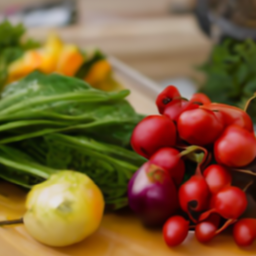

In [42]:
show_img(img)

In [47]:
path = "output/example_001.png"
save_img(img,path)

Image is saved to "output/example_001.png"
